# Tutorial 1.2 - CME Solution of a Bimolecular Reaction

## Here we examine a stochastic version of Tutorial 1.1 using Chemical Master Equation.

We use `jLM` to construct the CME system.

We need to import several libraries.  The first is [`jLM.CME`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CME.html#module-jLM.CME).  The second [`jLM.units`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.units.html#module-jLM.units) is a library to convert number with given units, such as *nm()*, *micron()*, *ms()*, *microsecond()*, etc.  Finally, we import the [`jLM.CMEPostProcessing`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CMEPostProcessing.html#module-jLM.CMEPostProcessing) standard library, which contains functionality used in biological simulations and post-processing commands including get traces and plotting.

In [1]:
# Import Standard Python Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import jLM Libraries
import jLM.CME as CME
import jLM.units as units
import jLM.CMEPostProcessing as PostProcessing

# Enable plotting inline in the Jupyter notebook
%matplotlib inline

ModuleNotFoundError: No module named 'jLM.CME'

In [2]:
# Import Standard Python Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Import pyLM Libraries
from pyLM import *
from pyLM.units import *
from pySTDLM import *
from pySTDLM.PostProcessing import *

# Enable plotting inline in the Jupyter notebook
%matplotlib inline

In [3]:
# Constants
V  = 1.0e-15       # L, general volume of E Coli
NA = 6.022e23      # molecules/mole

fold = 1 # multiply the rate constant by fold
kf_ODE = 1.07e6 *fold # /M/s
kr_ODE = 0.351 *fold # /s

kf = kf_ODE/(NA*V) # convert from 1.07e5 /M/s to /counts/s
kr = kr_ODE         # /s

## Define a CME Simulation

We begin by creating a [CMESimulation](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CME.html#jLM.CME.CMESimulation) Python object that we call `sim`. This object will include the definition of the whole stochastic simulation.

In [4]:
# Create our CME simulation object
sim = CME.CMESimulation(name='Bimolecule Reaction')

Next we define the chemical species with simulation. First. we specify the names of the chemical species.  Then we register these species to the simulation using [`defineSpecies()`](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function, which can be called multiple times and will add any new names to the list of species.


In [5]:
# Define our chemical species
species = ['A', 'B', 'C']
sim.defineSpecies(species)

Here we add reactions to the simulation. We use the [`addReaction()`](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function that is a member of the `CMESimulation` object. We add a bimolecular association reaction and a unimolecular dissociation reaction. When more than one reactant is involved, the list of reactant names should be passed as a tuple as can be seen in the reactant of the association reaction. 

The rates in this command must be in units of molecules and seconds, for instance units of `/molecule/sec` for the association reaction. One need to convert the macroscopic values in units of concentrations to of molecules as shown in the **Introduction**.


In [6]:
# Add reactions to the simulation
sim.addReaction(reactant=('A','B'), product='C', rate=kf)
sim.addReaction(reactant='C', product=('A','B'), rate=kr)

Next, we add the initial particle counts to the simulation using the [`addParticles()`](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/_autosummary/pyLM.CME.html#module-pyLM.CME) function.

In [7]:
# Set our initial species counts
sim.addParticles(species='A', count=50)
sim.addParticles(species='B', count=50)
sim.addParticles(species='C', count=0)

Finally, we define the simulation execution parameters. We have the simulation run for 30 seconds of real time saving results every 30 microseconds for a total of 1 million times. <br/>

Then we name the simulation output file and save the simulation definition to it.

In [8]:
# Define simulation parameters: run for 30 seconds, saving data every 30 ms
tstart =  0.0   # s
tend   = 30.0   # s
sim.setWriteInterval(units.microsecond(30))
sim.setSimulationTime(tend)
filename = "./T1.2-bimol.lm"
os.system("rm -rf %s"%(filename))
sim.save(filename)

In [9]:
# Print simulation parameters to the notebook for checking before final sim.run
sim

Specie,Particle ID,Initial Count
A,1,50
B,2,50
C,3,0
Reaction,Rate,Units
A + B ⟶ C,0.001776818332779807,molecule⁻¹sec⁻¹
C ⟶ A + B,0.351,s⁻¹


## Run Simulation with Different Replicates Number

Next we run the simulation. To do this, we specify which file has the problem specification (as saved two cells up). 

Lattice Microbes supports several different solvers for CME simulations; here we use the most common algorithm called the Gillespie's algorithm (aka the Stochastic Simulation Algorithm). You can learn more from Gillespie's [review paper](https://www.annualreviews.org/content/journals/10.1146/annurev.physchem.58.032806.104637) and [wikipedia page](https://en.wikipedia.org/wiki/Gillespie_algorithm).

Because the CME represents a stochastic process, each instance of a simulation will have a slightly different trajectory.  Generally, we run many "replicate" simulations with the same or nearly the same starting conditions and then compute aggregate statistics over all of them.

In [10]:
# Run reps replicates using the Direct Gillespie solver
reps = 10

sim.run(filename=filename, method="lm::cme::GillespieDSolver", replicates=reps)

  0%|          | 0/10 [00:00<?, ?it/s]

2025-07-07 15:23:09) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:09) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:09) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 1 and bottom word 992956481
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 10%|#         | 1/10 [00:00<00:02,  3.92it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 2 and bottom word 155155937
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 20%|##        | 2/10 [00:00<00:01,  5.33it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 3 and bottom word 295698489
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 30%|###       | 3/10 [00:00<00:01,  5.99it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 4 and bottom word 436985192
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 40%|####      | 4/10 [00:00<00:00,  6.28it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 5 and bottom word 584831623
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 50%|#####     | 5/10 [00:00<00:00,  6.43it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 6 and bottom word 734867879
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 60%|######    | 6/10 [00:00<00:00,  6.71it/s]

2025-07-07 15:23:10) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:10) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:10) Info: Data output thread running.
2025-07-07 15:23:10) Info: Seeding xorwow rng with top word 7 and bottom word 869376554
2025-07-07 15:23:10) Info: Data output thread finished.
2025-07-07 15:23:10) Info: Simulation file closed.


 70%|#######   | 7/10 [00:01<00:00,  6.80it/s]

2025-07-07 15:23:11) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:11) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:11) Info: Data output thread running.
2025-07-07 15:23:11) Info: Seeding xorwow rng with top word 8 and bottom word 12437093
2025-07-07 15:23:11) Info: Data output thread finished.
2025-07-07 15:23:11) Info: Simulation file closed.


 80%|########  | 8/10 [00:01<00:00,  6.85it/s]

2025-07-07 15:23:11) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:11) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:11) Info: Data output thread running.
2025-07-07 15:23:11) Info: Seeding xorwow rng with top word 9 and bottom word 157005537
2025-07-07 15:23:11) Info: Data output thread finished.
2025-07-07 15:23:11) Info: Simulation file closed.


 90%|######### | 9/10 [00:01<00:00,  6.93it/s]

2025-07-07 15:23:11) Info: Using 56 processor(s) and 1 CUDA device(s) per process.
2025-07-07 15:23:11) Info: Assigning 1.00 processor(s) and 1.00 CUDA device(s) per replicate.
2025-07-07 15:23:11) Info: Data output thread running.
2025-07-07 15:23:11) Info: Seeding xorwow rng with top word 10 and bottom word 296870616
2025-07-07 15:23:11) Info: Data output thread finished.
2025-07-07 15:23:11) Info: Simulation file closed.


100%|##########| 10/10 [00:01<00:00,  6.49it/s]


## Post-Process Analysis

### We first want to show you that jLM has its post-processing library, [`jLM.CMEPostProcessing`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CMEPostProcessing.html#module-jLM.CMEPostProcessing).

Post-processing generally begins by getting a handle to the file. This is accomplished by passing the filename to the function [`openLMFile()`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CMEPostProcessing.html#jLM.CMEPostProcessing.openLMFile). This function does some error checking to make sure the file is generated by LM. <br/>

The function [`plotTrace`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CMEPostProcessing.html#jLM.CMEPostProcessing.plotTrace) will plot a list of species from the specified simulation replicate.

Finally, we close the LM File. It is very important that if you open an LM file with the function `openLMFile` that it be closed at the end of your post-processing with [`closeLMFile`](https://forxhunter.github.io/LM2.5_doc/_autosummary/jLM.CMEPostProcessing.html#jLM.CMEPostProcessing.closeLMFile). The function takes the filehandle that is returned by `openLMFile` as an argument. Also, not that once this function is called, any function that takes the filehandle as an argument will fail to work as the handle is now stale.  This is a common mistake and if you get crashing, check that you haven't prematurely closed the file.  This function is usually called last in a post-processing script.



Plot the traces of one replicate `rep` to see the fluctuation.

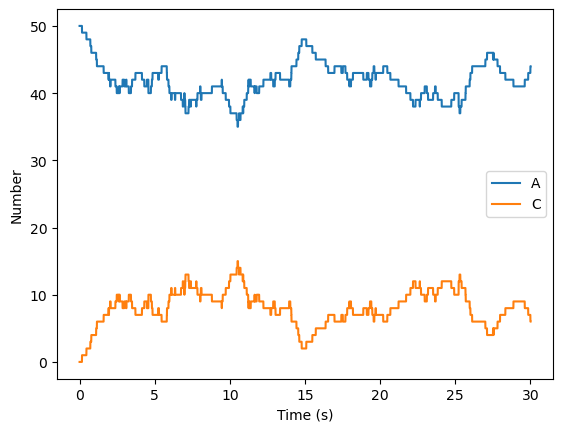

In [11]:
fieHandle = PostProcessing.openLMFile(filename)
rep = 5
PostProcessing.plotTrace(fieHandle, species=['A','C'], replicate=rep)
PostProcessing.closeLMFile(fieHandle)

Plot the population average and variance of species A and C among the replicates.

In [ ]:
fileHandle = PostProcessing.openLMFile(filename)
PostProcessing.plotAvgVar(fileHandle, species=['A','C'])
PostProcessing.closeLMFile(fileHandle)

However, the standard post-processing library has its limitations. 
1. First and foremost, it can only read in LM files generated during the simulation while in Whole Cell model, we are using CSV files to store all trajectories. 
2. Second, the built-in ploting functions can only plot line plot while we want more various plotting methods, including histogram, heatmap, etc. 
3. Third, these functions are generally slower than the normal Matplotlib functions.

### We will show a **more general method** to handle the trajectories from CME. 

We will read in the LM file to a 3D numpy array with dimensions (time, species, replicates) using h5py library. Then we can plot whatever we want by slicing this 3D array.

In [12]:
# Import Custom Analysis and Plotting Modules
import sys
sys.path.append('../analyze_scripts')
import custom_plot as plot

Serialize LM file into a 3D numpy array

In [13]:
fileHandle = PostProcessing.openLMFile(filename) # Create h5py file handle
timestep = PostProcessing.getTimesteps(fileHandle) # use PostProcessing to get the timesteps of the simulation

traces = np.zeros((len(timestep), len(sim.particleMap), reps)) # Initiate 3D array

# go to plot python script for more details
traces = plot.get_sim_data(traces, reps, filename) # Get 3D array

print('The size of the 3D trajectories is {0} with dimensions time, species, and replicates.'.format(np.shape(traces)))

The size of the 3D trajectories is (1000001, 3, 10) with dimensions time, species, and replicates.


Go to `fig_dir` to see the plots

In [14]:
# Create folder to store plotted figures
fig_dir = './plots_bimolecule/'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

Plot the traces of three species A, B, and C in one single replicate

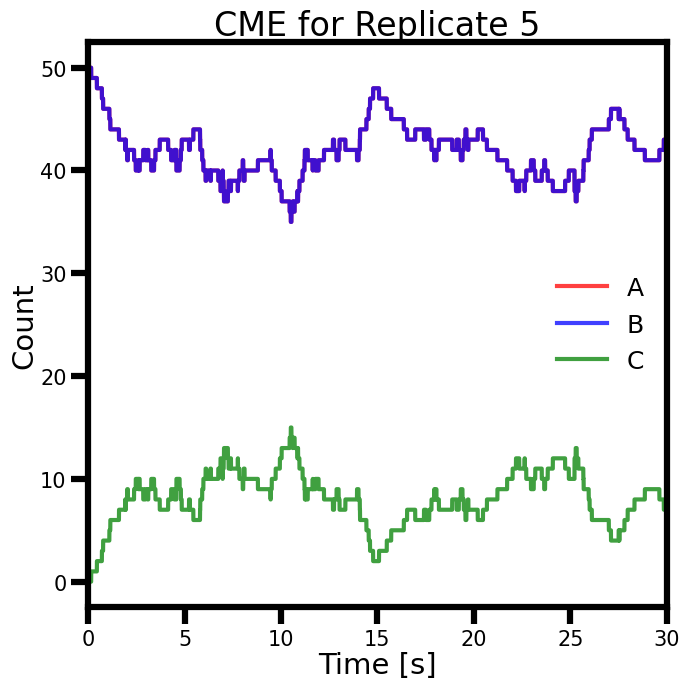

In [15]:
fig_name = 'bimolecule_CME_traces_rep{0}_{1}foldrates'.format(rep, fold)
fig_size = [7, 7] # Length by Height in inches
time = timestep
data_list=[traces[:,0:1,rep-1], traces[:,1:2,rep-1], traces[:,2:3,rep-1]]
legends = ['A','B','C']
colors = ['red', 'blue', 'green']
xlabel='Time [s]'
ylabel='Count'
title=f'CME for Replicate {rep}'
percentile = [0,100]

plot.plot_time_ranges(fig_dir, fig_name, fig_size,
               time, data_list, legends, colors, xlabel, ylabel, title,
               percentile, plot_avg=True, plot_range=False, xlimit=[tstart, tend],
               title_set=True, fonts_sizes=[21, 21, 24, 18],
               extension='.png', tick_setting=[12, 4.5, 15, 'out'], line_widths = [3,4.5],
               legend_pos='best')

Plot the average and full span of species 'A'

In [ ]:
specie = 'A'
fig_name = 'bimolecule_CME_{0}_{1}replicates_{2}foldrates'.format(specie, reps, fold)
fig_size = [7, 7] # Length by Height in inches
time = timestep
data_list=[traces[:,0,:]]
legends = ['A']
colors = ['red']
xlabel='Time [s]'
ylabel='Count'
title=f'CME of Specie {specie} in {reps} Replicates'
percentile = [0,100]

plot.plot_time_ranges(fig_dir, fig_name, fig_size,
               time, data_list, legends, colors, xlabel, ylabel, title,
               percentile, plot_avg=True, plot_range=True, xlimit=[tstart, tend],
               title_set=True, fonts_sizes=[21, 21, 24, 18],
               extension='.png', tick_setting=[12.0, 4.5, 15, 'out'], line_widths = [3,4.5],
               legend_pos='best')

Increase `reps` from 10 to 100 to get a better estimate of the mean and variance